In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGiNG")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'
strategy.ret.loc['2013-01-02'] = strategy.ret.loc['2013-01-03']

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-31 09:59:19,011 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:19,014 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:19,014 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

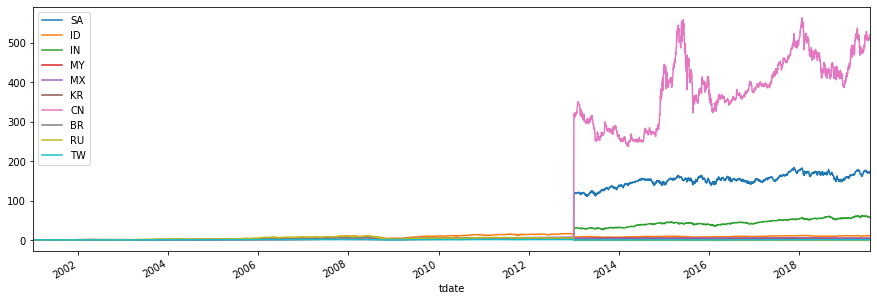

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

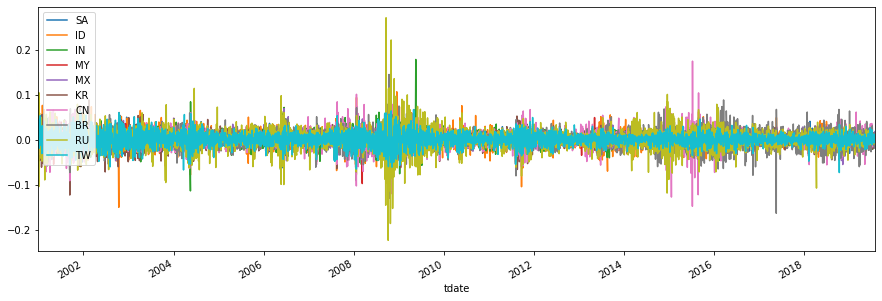

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [21*3, 21*6, 21*9, 21*12, 21*15, 21*18, 21*24]

## 1. X

### moving average 와 주가 차이

In [10]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [11]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [12]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [13]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EMPM_PAST.png">

<img src="./result/EMPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [15]:
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

### binary - 50%

In [16]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [17]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [18]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [19]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691414	valid_1's binary_logloss: 0.691414
[20]	training's binary_logloss: 0.689709	valid_1's binary_logloss: 0.689709
[30]	training's binary_logloss: 0.688274	valid_1's binary_logloss: 0.688274
[40]	training's binary_logloss: 0.686956	valid_1's binary_logloss: 0.686956
[50]	training's binary_logloss: 0.685778	valid_1's binary_logloss: 0.685778
[60]	training's binary_logloss: 0.684579	valid_1's binary_logloss: 0.684579
[70]	training's binary_logloss: 0.683374	valid_1's binary_logloss: 0.683374
[80]	training's binary_logloss: 0.682058	valid_1's binary_logloss: 0.682058
[90]	training's binary_logloss: 0.680908	valid_1's binary_logloss: 0.680908
[100]	training's binary_logloss: 0.679808	valid_1's binary_logloss: 0.679808
[110]	training's binary_logloss: 0.678849	valid_1's binary_logloss: 0.678849
[120]	training's binary_logloss: 0.677761	valid_1's binary_logloss: 0.677761
[130]	training's binary

In [22]:
test_pred = model.predict(df_test_x.values)

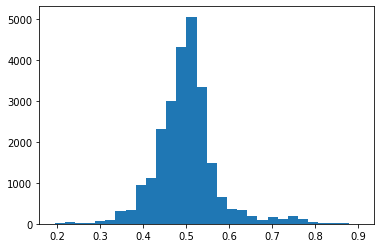

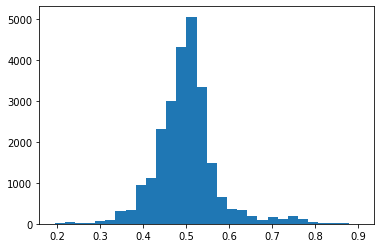

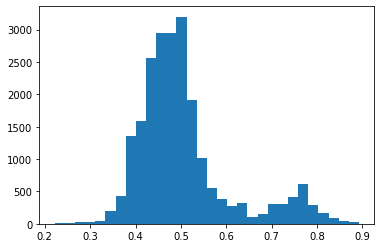

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='month', rebalance_weekday=1) 

2019-10-31 09:59:21,392 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
tester = Tester(strategy)

In [32]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [33]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 09:59:21,422 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:21,423 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:21,424 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:59:28,169 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:59:28,170 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:59:29,760 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:59:29,765 - EMPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 09:59:30,763 - EMPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 09:59:30,765 - EMPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 09:59:30,766 - EMPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 09:59:30,766 - EMPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 09:59:33,332 - EMPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITIO

### TRAIN

2019-10-31 09:59:34,468 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:34,468 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:34,475 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:34,481 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


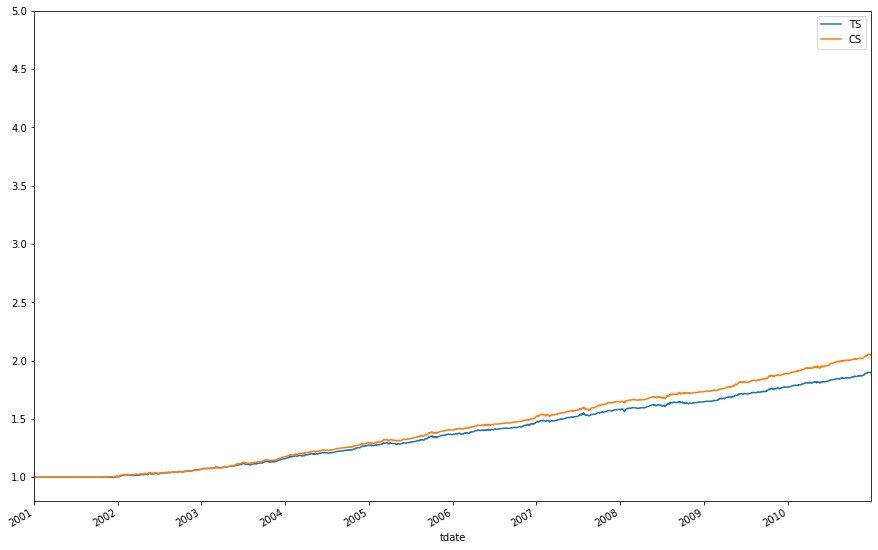

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:59:34,629 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:34,629 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:34,635 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:34,641 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


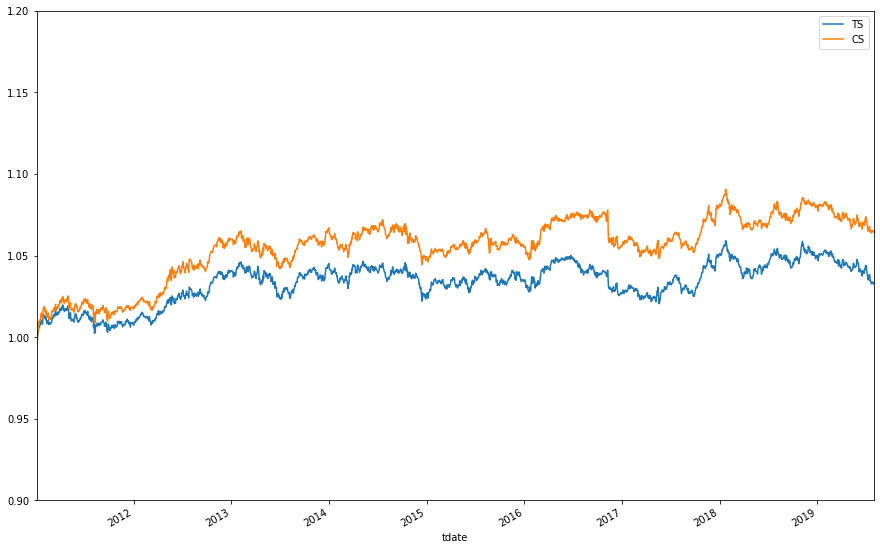

In [35]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [42]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.669827	valid_1's binary_logloss: 0.705187
[20]	training's binary_logloss: 0.666798	valid_1's binary_logloss: 0.703432
[30]	training's binary_logloss: 0.663992	valid_1's binary_logloss: 0.702049
[40]	training's binary_logloss: 0.661389	valid_1's binary_logloss: 0.70104
[50]	training's binary_logloss: 0.659025	valid_1's binary_logloss: 0.700567
[60]	training's binary_logloss: 0.656606	valid_1's binary_logloss: 0.700242
[70]	training's binary_logloss: 0.65419	valid_1's binary_logloss: 0.699622
[80]	training's binary_logloss: 0.651841	valid_1's binary_logloss: 0.699372
[90]	training's binary_logloss: 0.649777	valid_1's binary_logloss: 0.699055
[100]	training's binary_logloss: 0.647631	valid_1's binary_logloss: 0.698518
[110]	training's binary_logloss: 0.645431	valid_1's binary_logloss: 0.698339
[120]	training's binary_logloss: 0.643499	valid_1's binary_logloss: 0.698287
[130]	training's binary_l

In [43]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([2.000e+01, 1.100e+01, 4.000e+00, 2.200e+01, 4.500e+01, 5.300e+01,
        1.130e+02, 2.510e+02, 3.210e+02, 4.850e+02, 4.430e+02, 5.880e+02,
        9.120e+02, 1.269e+03, 2.019e+03, 3.027e+03, 4.359e+03, 6.342e+03,
        6.248e+03, 5.242e+03, 6.736e+03, 3.579e+03, 1.572e+03, 7.980e+02,
        4.360e+02, 6.700e+02, 6.830e+02, 4.630e+02, 2.990e+02, 1.700e+02]),
 array([0.05182753, 0.08083402, 0.10984052, 0.13884701, 0.16785351,
        0.19686   , 0.2258665 , 0.254873  , 0.28387949, 0.31288599,
        0.34189248, 0.37089898, 0.39990547, 0.42891197, 0.45791846,
        0.48692496, 0.51593145, 0.54493795, 0.57394444, 0.60295094,
        0.63195743, 0.66096393, 0.68997042, 0.71897692, 0.74798341,
        0.77698991, 0.8059964 , 0.8350029 , 0.86400939, 0.89301589,
        0.92202238]),
 <a list of 30 Patch objects>)

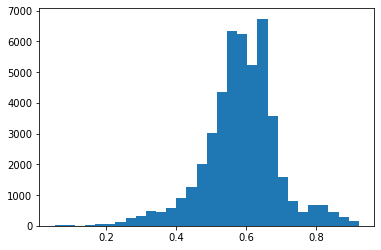

In [44]:
plt.hist(pred2, bins=30)

In [45]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [46]:
strategy2 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'
strategy2.ret.loc['2013-01-02'] = strategy2.ret.loc['2013-01-03']


strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-31 09:59:35,748 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:35,748 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:35,749 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:35,749 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:35,750 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:59:35,750 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [47]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 09:59:35,779 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:59:35,779 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:59:35,779 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:35,779 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:35,780 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:35,780 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:35,781 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:59:35,781 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:59:42,559 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:59:42,559 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:59:42,560 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:59:42,560 - EMPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:59:44,160 - EMPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:59:44

### TRAIN

2019-10-31 09:59:48,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:48,851 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:48,853 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:48,853 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:48,860 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:48,860 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:48,866 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:59:48,866 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


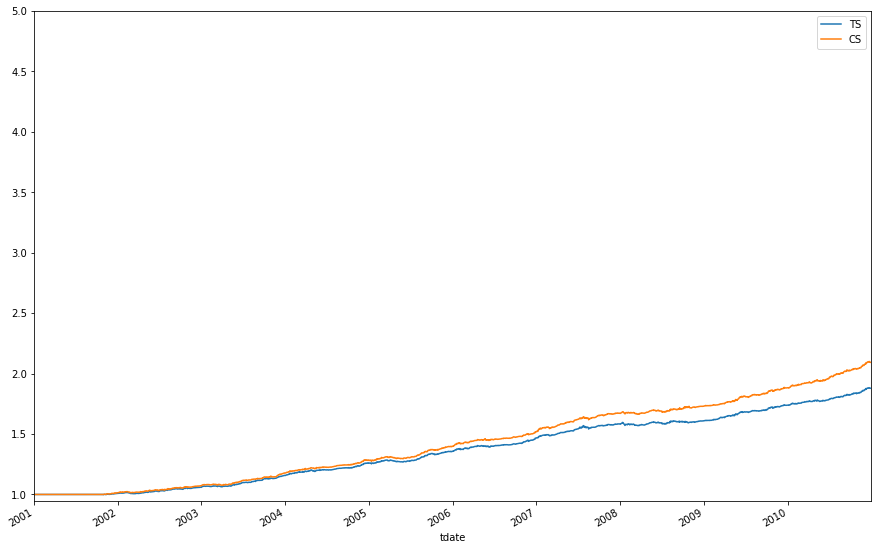

In [48]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 09:59:49,016 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:49,016 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:59:49,017 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:49,017 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 09:59:49,023 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:49,023 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 09:59:49,029 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:59:49,029 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


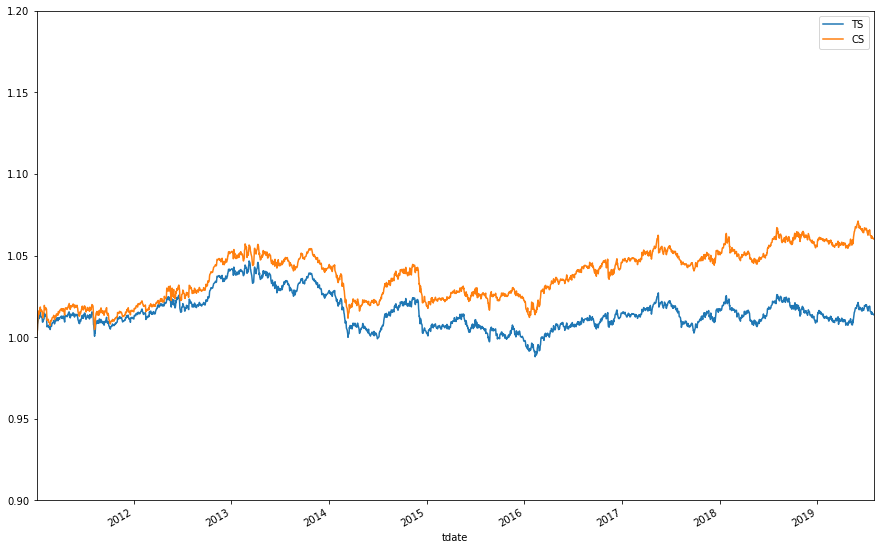

In [49]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.2))

# CASE 3. Case1을 Rolling으로 실행

In [50]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [52]:
models = []
train_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691414	valid_1's binary_logloss: 0.693249
[20]	training's binary_logloss: 0.689709	valid_1's binary_logloss: 0.693055
[30]	training's binary_logloss: 0.688274	valid_1's binary_logloss: 0.693197
[40]	training's binary_logloss: 0.686956	valid_1's binary_logloss: 0.693452
[50]	training's binary_logloss: 0.685778	valid_1's binary_logloss: 0.693437
[60]	training's binary_logloss: 0.684579	valid_1's binary_logloss: 0.693421
[70]	training's binary_logloss: 0.683374	valid_1's binary_logloss: 0.69317
[80]	training's binary_logloss: 0.682058	valid_1's binary_logloss: 0.69283
[90]	training's binary_logloss: 0.680908	valid_1's binary_logloss: 0.692774
[100]	training's binary_logloss: 0.679808	valid_1's binary_logloss: 0.692688
[110]	training's binary_logloss: 0.678849	valid_1's binary_logloss: 0.692664
[120]	training's binary_logloss: 0.677761	valid_1's binary_logloss: 0.692831
[130]	training's binary_l

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691574	valid_1's binary_logloss: 0.692691
[20]	training's binary_logloss: 0.690026	valid_1's binary_logloss: 0.692232
[30]	training's binary_logloss: 0.688678	valid_1's binary_logloss: 0.692257
[40]	training's binary_logloss: 0.687484	valid_1's binary_logloss: 0.692232
[50]	training's binary_logloss: 0.686278	valid_1's binary_logloss: 0.692027
[60]	training's binary_logloss: 0.685127	valid_1's binary_logloss: 0.691803
[70]	training's binary_logloss: 0.683889	valid_1's binary_logloss: 0.691791
[80]	training's binary_logloss: 0.682798	valid_1's binary_logloss: 0.691736
[90]	training's binary_logloss: 0.681834	valid_1's binary_logloss: 0.691792
[100]	training's binary_logloss: 0.681004	valid_1's binary_logloss: 0.691809
[110]	training's binary_logloss: 0.680147	valid_1's binary_logloss: 0.69178
[120]	training's binary_logloss: 0.679239	valid_1's binary_logloss: 0.691945
[130]	training's binary_

[200]	training's binary_logloss: 0.674989	valid_1's binary_logloss: 0.683036
[210]	training's binary_logloss: 0.674165	valid_1's binary_logloss: 0.683742
[220]	training's binary_logloss: 0.673379	valid_1's binary_logloss: 0.683218
[230]	training's binary_logloss: 0.672701	valid_1's binary_logloss: 0.683159
[240]	training's binary_logloss: 0.671904	valid_1's binary_logloss: 0.683167
[250]	training's binary_logloss: 0.671123	valid_1's binary_logloss: 0.682849
[260]	training's binary_logloss: 0.670417	valid_1's binary_logloss: 0.682992
[270]	training's binary_logloss: 0.669551	valid_1's binary_logloss: 0.683076
[280]	training's binary_logloss: 0.668971	valid_1's binary_logloss: 0.683435
[290]	training's binary_logloss: 0.668314	valid_1's binary_logloss: 0.683258
[300]	training's binary_logloss: 0.667569	valid_1's binary_logloss: 0.683556
[310]	training's binary_logloss: 0.666839	valid_1's binary_logloss: 0.684054
[320]	training's binary_logloss: 0.666164	valid_1's binary_logloss: 0.68406


[340]	training's binary_logloss: 0.664015	valid_1's binary_logloss: 0.707536
[350]	training's binary_logloss: 0.663397	valid_1's binary_logloss: 0.708128
[360]	training's binary_logloss: 0.662712	valid_1's binary_logloss: 0.708873
[370]	training's binary_logloss: 0.662084	valid_1's binary_logloss: 0.709109
[380]	training's binary_logloss: 0.661471	valid_1's binary_logloss: 0.710045
[390]	training's binary_logloss: 0.660892	valid_1's binary_logloss: 0.710709
[400]	training's binary_logloss: 0.660327	valid_1's binary_logloss: 0.711454
[410]	training's binary_logloss: 0.659677	valid_1's binary_logloss: 0.711779
[420]	training's binary_logloss: 0.659106	valid_1's binary_logloss: 0.71236
[430]	training's binary_logloss: 0.658462	valid_1's binary_logloss: 0.713063
[440]	training's binary_logloss: 0.657869	valid_1's binary_logloss: 0.713422
[450]	training's binary_logloss: 0.657282	valid_1's binary_logloss: 0.713795
[460]	training's binary_logloss: 0.656655	valid_1's binary_logloss: 0.714198


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.691836	valid_1's binary_logloss: 0.692911
[20]	training's binary_logloss: 0.690685	valid_1's binary_logloss: 0.693015
[30]	training's binary_logloss: 0.689616	valid_1's binary_logloss: 0.692909
[40]	training's binary_logloss: 0.6886	valid_1's binary_logloss: 0.692562
[50]	training's binary_logloss: 0.687652	valid_1's binary_logloss: 0.692169
[60]	training's binary_logloss: 0.686742	valid_1's binary_logloss: 0.691903
[70]	training's binary_logloss: 0.685853	valid_1's binary_logloss: 0.691813
[80]	training's binary_logloss: 0.684991	valid_1's binary_logloss: 0.691602
[90]	training's binary_logloss: 0.684172	valid_1's binary_logloss: 0.691603
[100]	training's binary_logloss: 0.683409	valid_1's binary_logloss: 0.691455
[110]	training's binary_logloss: 0.682702	valid_1's binary_logloss: 0.691253
[120]	training's binary_logloss: 0.681978	valid_1's binary_logloss: 0.691187
[130]	training's binary_l

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([  21.,   43.,   50.,  159.,   44.,   50.,   16.,   96.,  125.,
         199.,  543., 1143., 2331., 2431., 3509., 3074., 2718., 1479.,
         981.,  736.,  572.,  405.,  335.,  334.,  113.,  140.,  159.,
         242.,   48.,  254.]),
 array([0.17462166, 0.19561765, 0.21661365, 0.23760965, 0.25860565,
        0.27960165, 0.30059764, 0.32159364, 0.34258964, 0.36358564,
        0.38458164, 0.40557763, 0.42657363, 0.44756963, 0.46856563,
        0.48956163, 0.51055762, 0.53155362, 0.55254962, 0.57354562,
        0.59454162, 0.61553761, 0.63653361, 0.65752961, 0.67852561,
        0.69952161, 0.7205176 , 0.7415136 , 0.7625096 , 0.7835056 ,
        0.8045016 ]),
 <a list of 30 Patch objects>)

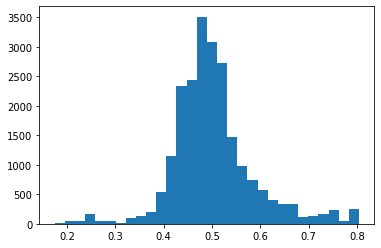

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'
strategy3.ret.loc['2013-01-02'] = strategy3.ret.loc['2013-01-03']


strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-31 09:59:55,683 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:55,683 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:55,683 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 09:59:55,685 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:55,685 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:55,685 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:59:55,686 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:59:55,686 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:59:55,686 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 09:59:55,715 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:59:55,715 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:59:55,715 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:59:55,716 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:55,716 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:55,716 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:59:55,717 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:55,717 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:55,717 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:59:55,718 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:59:55,718 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:59:55,718 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 10:00:02,495 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 10:00:02,495 - EMPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 10:00:

2019-10-31 10:00:05,495 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:05,495 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:05,495 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:05,497 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:05,497 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:05,497 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:05,505 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:05,505 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:05,505 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:05,512 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 10:00:05,512 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 10:00:05,512 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT


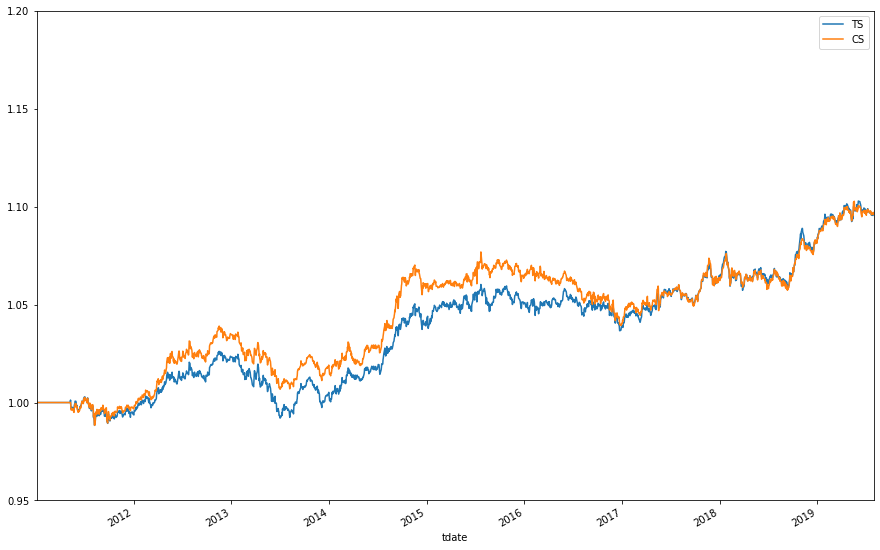

In [59]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))

# CASE 4. CASE 2를 ROLLING으로 실행

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.669827	valid_1's binary_logloss: 0.71413
[20]	training's binary_logloss: 0.666798	valid_1's binary_logloss: 0.714889
[30]	training's binary_logloss: 0.663992	valid_1's binary_logloss: 0.715729
[40]	training's binary_logloss: 0.661389	valid_1's binary_logloss: 0.716139
[50]	training's binary_logloss: 0.659025	valid_1's binary_logloss: 0.716243
[60]	training's binary_logloss: 0.656606	valid_1's binary_logloss: 0.716325
[70]	training's binary_logloss: 0.65419	valid_1's binary_logloss: 0.716575
[80]	training's binary_logloss: 0.651841	valid_1's binary_logloss: 0.716983
[90]	training's binary_logloss: 0.649777	valid_1's binary_logloss: 0.717056
[100]	training's binary_logloss: 0.647631	valid_1's binary_logloss: 0.717327
[110]	training's binary_logloss: 0.645431	valid_1's binary_logloss: 0.717843
[120]	training's binary_logloss: 0.643499	valid_1's binary_logloss: 0.71823
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[70]	training's binary_logloss: 0.655579	valid_1's binary_logloss: 0.703905
[80]	training's binary_logloss: 0.653323	valid_1's binary_logloss: 0.702027
[90]	training's binary_logloss: 0.651437	valid_1's binary_logloss: 0.701179
[100]	training's binary_logloss: 0.649672	valid_1's binary_logloss: 0.700299
[110]	training's binary_logloss: 0.648062	valid_1's binary_logloss: 0.699047
[120]	training's binary_logloss: 0.646313	valid_1's binary_logloss: 0.697633
[130]	training's binary_logloss: 0.64469	valid_1's binary_logloss: 0.696432
[140]	training's binary_logloss: 0.643154	valid_1's binary_logloss: 0.695249
[150]	training's binary_logloss: 0.641654	valid_1's binary_logloss: 0.693715
[160]	training's binary_logloss: 0.64012	valid_1's binary_logloss: 0.692745
[170]	training's binary_logloss: 0.638649	valid_1's binary_logloss: 0.691677
[180]	training's binary_logloss: 0.637329	valid_1's binary_logloss: 0.69125
[190]	training's binary_logloss: 0.635885	valid_1's binary_logloss: 0.690281
[200

[280]	training's binary_logloss: 0.62305	valid_1's binary_logloss: 0.734546
[290]	training's binary_logloss: 0.62176	valid_1's binary_logloss: 0.735093
[300]	training's binary_logloss: 0.620386	valid_1's binary_logloss: 0.735531
[310]	training's binary_logloss: 0.618885	valid_1's binary_logloss: 0.73612
[320]	training's binary_logloss: 0.617603	valid_1's binary_logloss: 0.736224
[330]	training's binary_logloss: 0.616351	valid_1's binary_logloss: 0.736892
[340]	training's binary_logloss: 0.615026	valid_1's binary_logloss: 0.737847
[350]	training's binary_logloss: 0.613761	valid_1's binary_logloss: 0.739057
[360]	training's binary_logloss: 0.612604	valid_1's binary_logloss: 0.739509
[370]	training's binary_logloss: 0.611202	valid_1's binary_logloss: 0.738844
[380]	training's binary_logloss: 0.609772	valid_1's binary_logloss: 0.738771
[390]	training's binary_logloss: 0.608522	valid_1's binary_logloss: 0.739512
[400]	training's binary_logloss: 0.607228	valid_1's binary_logloss: 0.73967
[41

[420]	training's binary_logloss: 0.603604	valid_1's binary_logloss: 0.727602
[430]	training's binary_logloss: 0.602269	valid_1's binary_logloss: 0.727373
[440]	training's binary_logloss: 0.601194	valid_1's binary_logloss: 0.727849
[450]	training's binary_logloss: 0.599999	valid_1's binary_logloss: 0.727816
[460]	training's binary_logloss: 0.598999	valid_1's binary_logloss: 0.727581
[470]	training's binary_logloss: 0.59771	valid_1's binary_logloss: 0.727596
[480]	training's binary_logloss: 0.596665	valid_1's binary_logloss: 0.727466
[490]	training's binary_logloss: 0.595539	valid_1's binary_logloss: 0.727036
[500]	training's binary_logloss: 0.594461	valid_1's binary_logloss: 0.726846
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.594461	valid_1's binary_logloss: 0.726846
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670255	valid_1's binary_logloss: 0.713137
[20]	training's binary_logloss: 0.667733	vali

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.670355	valid_1's binary_logloss: 0.740012
[20]	training's binary_logloss: 0.668029	valid_1's binary_logloss: 0.739579
[30]	training's binary_logloss: 0.666036	valid_1's binary_logloss: 0.736613
[40]	training's binary_logloss: 0.664076	valid_1's binary_logloss: 0.735653
[50]	training's binary_logloss: 0.662403	valid_1's binary_logloss: 0.734989
[60]	training's binary_logloss: 0.660794	valid_1's binary_logloss: 0.734618
[70]	training's binary_logloss: 0.659213	valid_1's binary_logloss: 0.73396
[80]	training's binary_logloss: 0.657608	valid_1's binary_logloss: 0.732178
[90]	training's binary_logloss: 0.65612	valid_1's binary_logloss: 0.730714
[100]	training's binary_logloss: 0.65455	valid_1's binary_logloss: 0.729272
[110]	training's binary_logloss: 0.653074	valid_1's binary_logloss: 0.728249
[120]	training's binary_logloss: 0.651622	valid_1's binary_logloss: 0.726897
[130]	training's binary_lo

In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [63]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [64]:
strategy4 = EmergingStrategy(strategy_name="EMPM", asset_type="EMERGING")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'
strategy4.ret.loc['2013-01-02'] = strategy4.ret.loc['2013-01-03']


strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-31 10:00:10,731 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 10:00:10,731 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 10:00:10,731 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 10:00:10,731 - EMPM - INFO - [STEP 0] START LOGGING EMPM
2019-10-31 10:00:10,734 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 10:00:10,734 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 10:00:10,734 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 10:00:10,734 - EMPM - INFO - [STEP 1] LOAD DATA
2019-10-31 10:00:10,737 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 10:00:10,737 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 10:00:10,737 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 10:00:10,737 - EMPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 10:00:10,773 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 10:00:10,773 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 10:00:10,773 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 10:00:10,773 - EMPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 10:00:10,774 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 10:00:10,774 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 10:00:10,774 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 10:00:10,774 - EMPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 10:00:10,775 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 10:00:10,775 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 10:00:10,775 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 10:00:10,775 - EMPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 10:00:10,777 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 10:00:10,777 - EMPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 10:00:10,777 

2019-10-31 10:00:20,615 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:20,615 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:20,615 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:20,615 - EMPM - INFO - [STEP 6] START BACKTEST
2019-10-31 10:00:20,617 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:20,617 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:20,617 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:20,617 - EMPM - INFO - [STEP 6 - 1] BACKTEST EMPM TIME SERIES
2019-10-31 10:00:20,624 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:20,624 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:20,624 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:20,624 - EMPM - INFO - [STEP 6 - 2] BACKTEST EMPM CROSS SECTIONAL
2019-10-31 10:00:20,632 - EMPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 10:00:20,632 - 

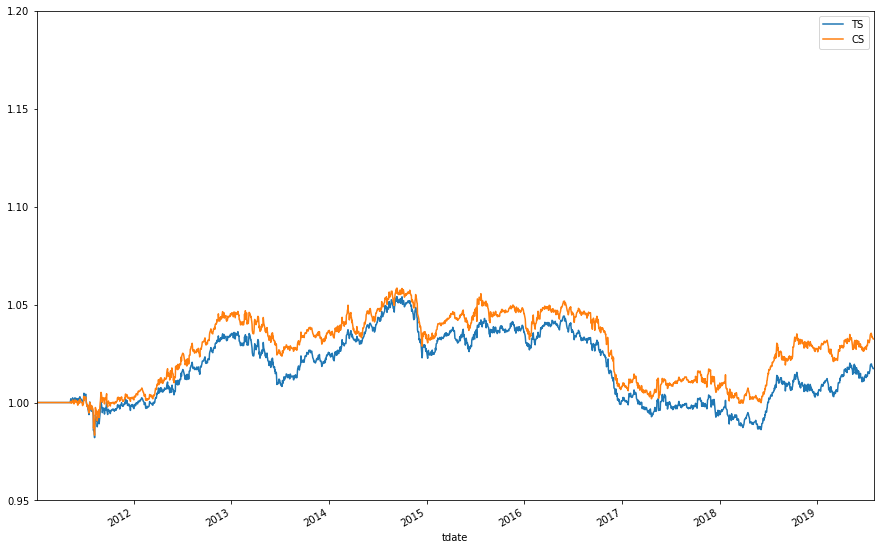

In [66]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.2))